In [1]:
!pip install tf-nightly

INFO: pip is looking at multiple versions of tf-nightly to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tf-nightly to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 MB 503.3 kB/s eta 0:00:0000:0100:10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 469.0 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.1/348.1 kB 893.2 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 1.0 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 1.4 MB/s eta 0:00:0000:0100:01m
  Attemptin

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import time

In [2]:
zip_file_path = './task2.zip'
extraction_directory = 'extracted_images/'

In [3]:
y_train = pd.read_csv(extraction_directory + 'y_train.csv', index_col='id')
y_train_np = y_train.to_numpy()

In [4]:
X_train = pd.read_csv(extraction_directory + 'X_train.csv', index_col='id')
X_train_np = X_train.to_numpy()

In [5]:
def replicate_row(row):
    # Find the length of the non-NaN part
    valid_length = np.argmax(row.isna())
    valid_length = valid_length if valid_length > 0 else len(row)

    # Repeat the non-NaN part and truncate to match the original length
    repeated = np.tile(row[:valid_length], len(row) // valid_length + 1)[:len(row)]
    return pd.Series(repeated)

start = time.time()

X_train_periodic = X_train.apply(replicate_row, axis=1)

end = time.time()
print(f"Time taken: {end - start} seconds")

Time taken: 1.2521181106567383 seconds


In [6]:
def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res

# ms_flt_array = [0.2,0.6]
ms_flt_array = [0.4,0.8]

def make_periodic(data, ms_flt_array):
    data = data.copy()

    for i in range(0, len(ms_flt_array)):
        window_size = get_median_filter_width(300, ms_flt_array[i])

        data -= data.apply(lambda x: x.rolling(window=window_size, center=True, min_periods=1).median(), axis=1)

    return data

X_train_filtered = make_periodic(X_train_periodic, ms_flt_array)
X_train_filtered_np = X_train_filtered.to_numpy()

KeyboardInterrupt: 

In [ ]:

def make_periodic(data, ms_flt_array):
    data = data.copy()

    for i in range(0, len(ms_flt_array)):
        window_size = get_median_filter_width(300, ms_flt_array[i])

        data -= data.apply(lambda x: x.rolling(window=window_size, center=True, min_periods=1).median(), axis=1)

    return data

In [ ]:
total_length = X_train.shape[1]

def denoise_signal(signal, wavelet, level):
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(signal, wavelet, level=level)

    # Calculate a threshold
    sigma = np.median(np.abs(coeff[-level])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))

    # Thresholding
    coeff[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coeff[1:])

    # Reconstruct the signal
    return pywt.waverec(coeff, wavelet)

def denoise_signal_with_selective_thresholding(signal, wavelet, level, qrs_band=(5, 15), sampling_rate=300, dampening=2):
    # Decompose to get the wavelet coefficients
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Calculate the frequency bands for each level of decomposition
    freqs = pywt.scale2frequency(wavelet, [1, 2, 4, 8, 16, 32, 64]) * sampling_rate

    # Calculate a universal threshold
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))

    # Apply selective thresholding
    new_coeffs = []
    for i, coeff in enumerate(coeffs[1:], start=1):  # Skip the approximation coefficients
        if freqs[i-1] >= qrs_band[0] and freqs[i-1] <= qrs_band[1]:
            # If within QRS band, apply a softer threshold or skip thresholding
            new_coeffs.append(pywt.threshold(coeff, value=threshold/dampening, mode='soft'))
        else:
            # Else, apply the regular threshold
            new_coeffs.append(pywt.threshold(coeff, value=threshold, mode='soft'))
    
    # Reconstruct the signal using modified coefficients
    coeffs[1:] = new_coeffs
    return pywt.waverec(coeffs, wavelet)

def process_signal(signal, wavelet, level, qrs_band=(5, 15), sampling_rate=300, dampening=2):
    global total_length
    # Find the index of the first NaN value
    nan_index = np.argmax(np.isnan(signal))
    if nan_index == 0:  # No NaNs found
        return denoise_signal_with_selective_thresholding(signal, wavelet, level, qrs_band=qrs_band, sampling_rate=sampling_rate, dampening=dampening)
    
    a = np.empty((total_length-nan_index,))
    a[:] = np.nan

    return np.concatenate([denoise_signal_with_selective_thresholding(signal[:nan_index], wavelet, level, qrs_band=qrs_band, sampling_rate=sampling_rate, dampening=dampening), a])[0:total_length]

In [ ]:
wavelet = 'db4'  # Example wavelet, choose as per your requirement
level = 3 # Decomposition level
qrs_band = (50, 150)  # Frequency band of QRS complex in Hz
sampling_rate = 300  # Sampling rate of ECG signal in Hz
dampening = 1

X_train_denoised_np = np.array([process_signal(row, wavelet, level, qrs_band, sampling_rate, dampening)[0:total_length] for row in X_train_filtered_np])
X_train_denoised = pd.DataFrame(data=X_train_denoised_np, columns=X_train.columns, index=X_train.index)

In [ ]:
from biosppy.signals.ecg import correct_rpeaks
from ecgdetectors import Detectors
# from sklearn.preprocessing import RobustScaler, StandardScaler

In [ ]:
def normalize_signal(signal):

    detectors = Detectors(300)

    r_peaks = correct_rpeaks(signal, np.asarray(detectors.pan_tompkins_detector(signal)), 300, 0.2)['rpeaks']
    vals_peaks = signal[r_peaks]
    median_peak_val = np.median(vals_peaks[~np.isnan(vals_peaks)])
    
    if median_peak_val != 0:
        if np.isnan(median_peak_val).any():
            print(median_peak_val)
        return signal / median_peak_val
    # else:
    #     print(median_peak_val)
    #     return RobustScaler(quantile_range=(.2,.8)).fit_transform(signal.T).T/5

X_train_transformed_np = np.apply_along_axis(normalize_signal, 1, X_train_denoised_np)
X_train_transformed = pd.DataFrame(data=X_train_transformed_np, columns=X_train.columns, index=X_train.index)

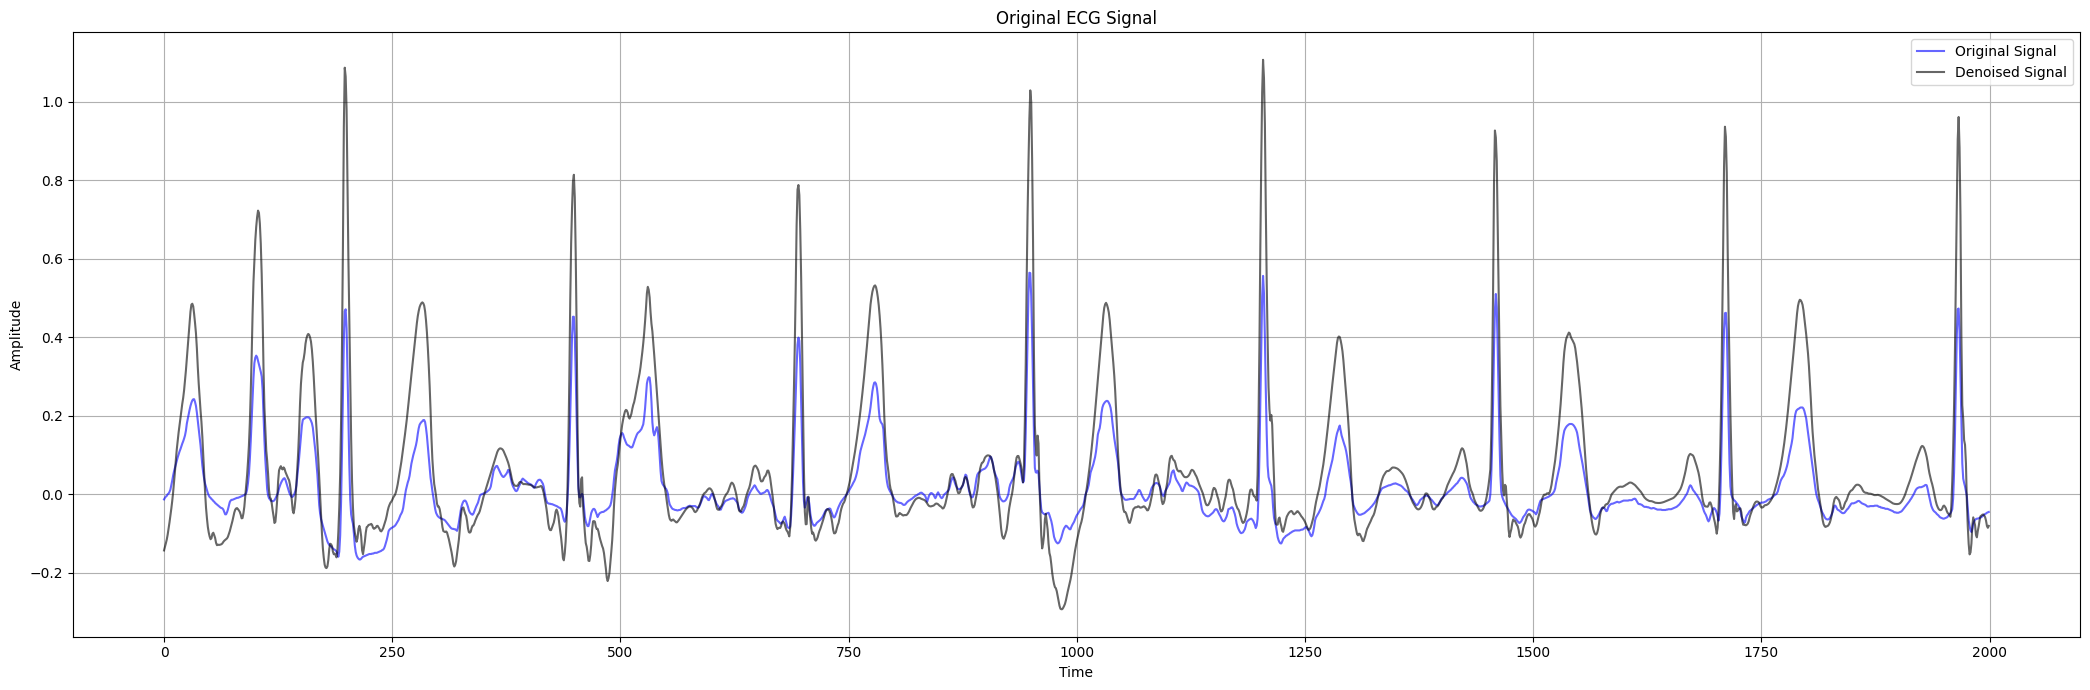

In [ ]:
plot_start = 0
plot_length = 2000
index = 0

plt.figure(figsize=(21, 7))
plt.plot(range(plot_start, plot_length), X_train_np[index,plot_start:plot_length]/600, label='Original Signal', color='blue', alpha=.6)
plt.plot(range(plot_start, plot_length), X_train_transformed_np[index,plot_start:plot_length], label='Denoised Signal', color='black', alpha=.6)
# plt.plot(denoised_data_np[j,:plot_length], label='Denoised Signal', color='black')

plt.title('Original ECG Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
#plt.ylim((-10,10))
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Retrieve one sample recording per class for plotting
labels_array = y_train['y'].to_numpy()
num_classes = 4
num = 10
offset = 10
sample_signal_ids = []
for class_id in range(num_classes):
    sample_signal_ids.append(X_train.index[np.argwhere(labels_array == class_id)[offset:offset+num].squeeze().tolist()].to_list())
    
# Print indices of the sample signals
sample_signal_ids

[[21, 23, 24, 25, 27, 31, 32, 34, 35, 37],
 [123, 126, 128, 131, 138, 144, 145, 165, 187, 188],
 [36, 38, 40, 44, 47, 48, 49, 54, 55, 58],
 [291, 317, 333, 438, 448, 501, 527, 664, 690, 763]]

/var/folders/n2/rfc_8wbn4n5bqd9_rm70nslh0000gn/T/ipykernel_64844/2767500285.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')


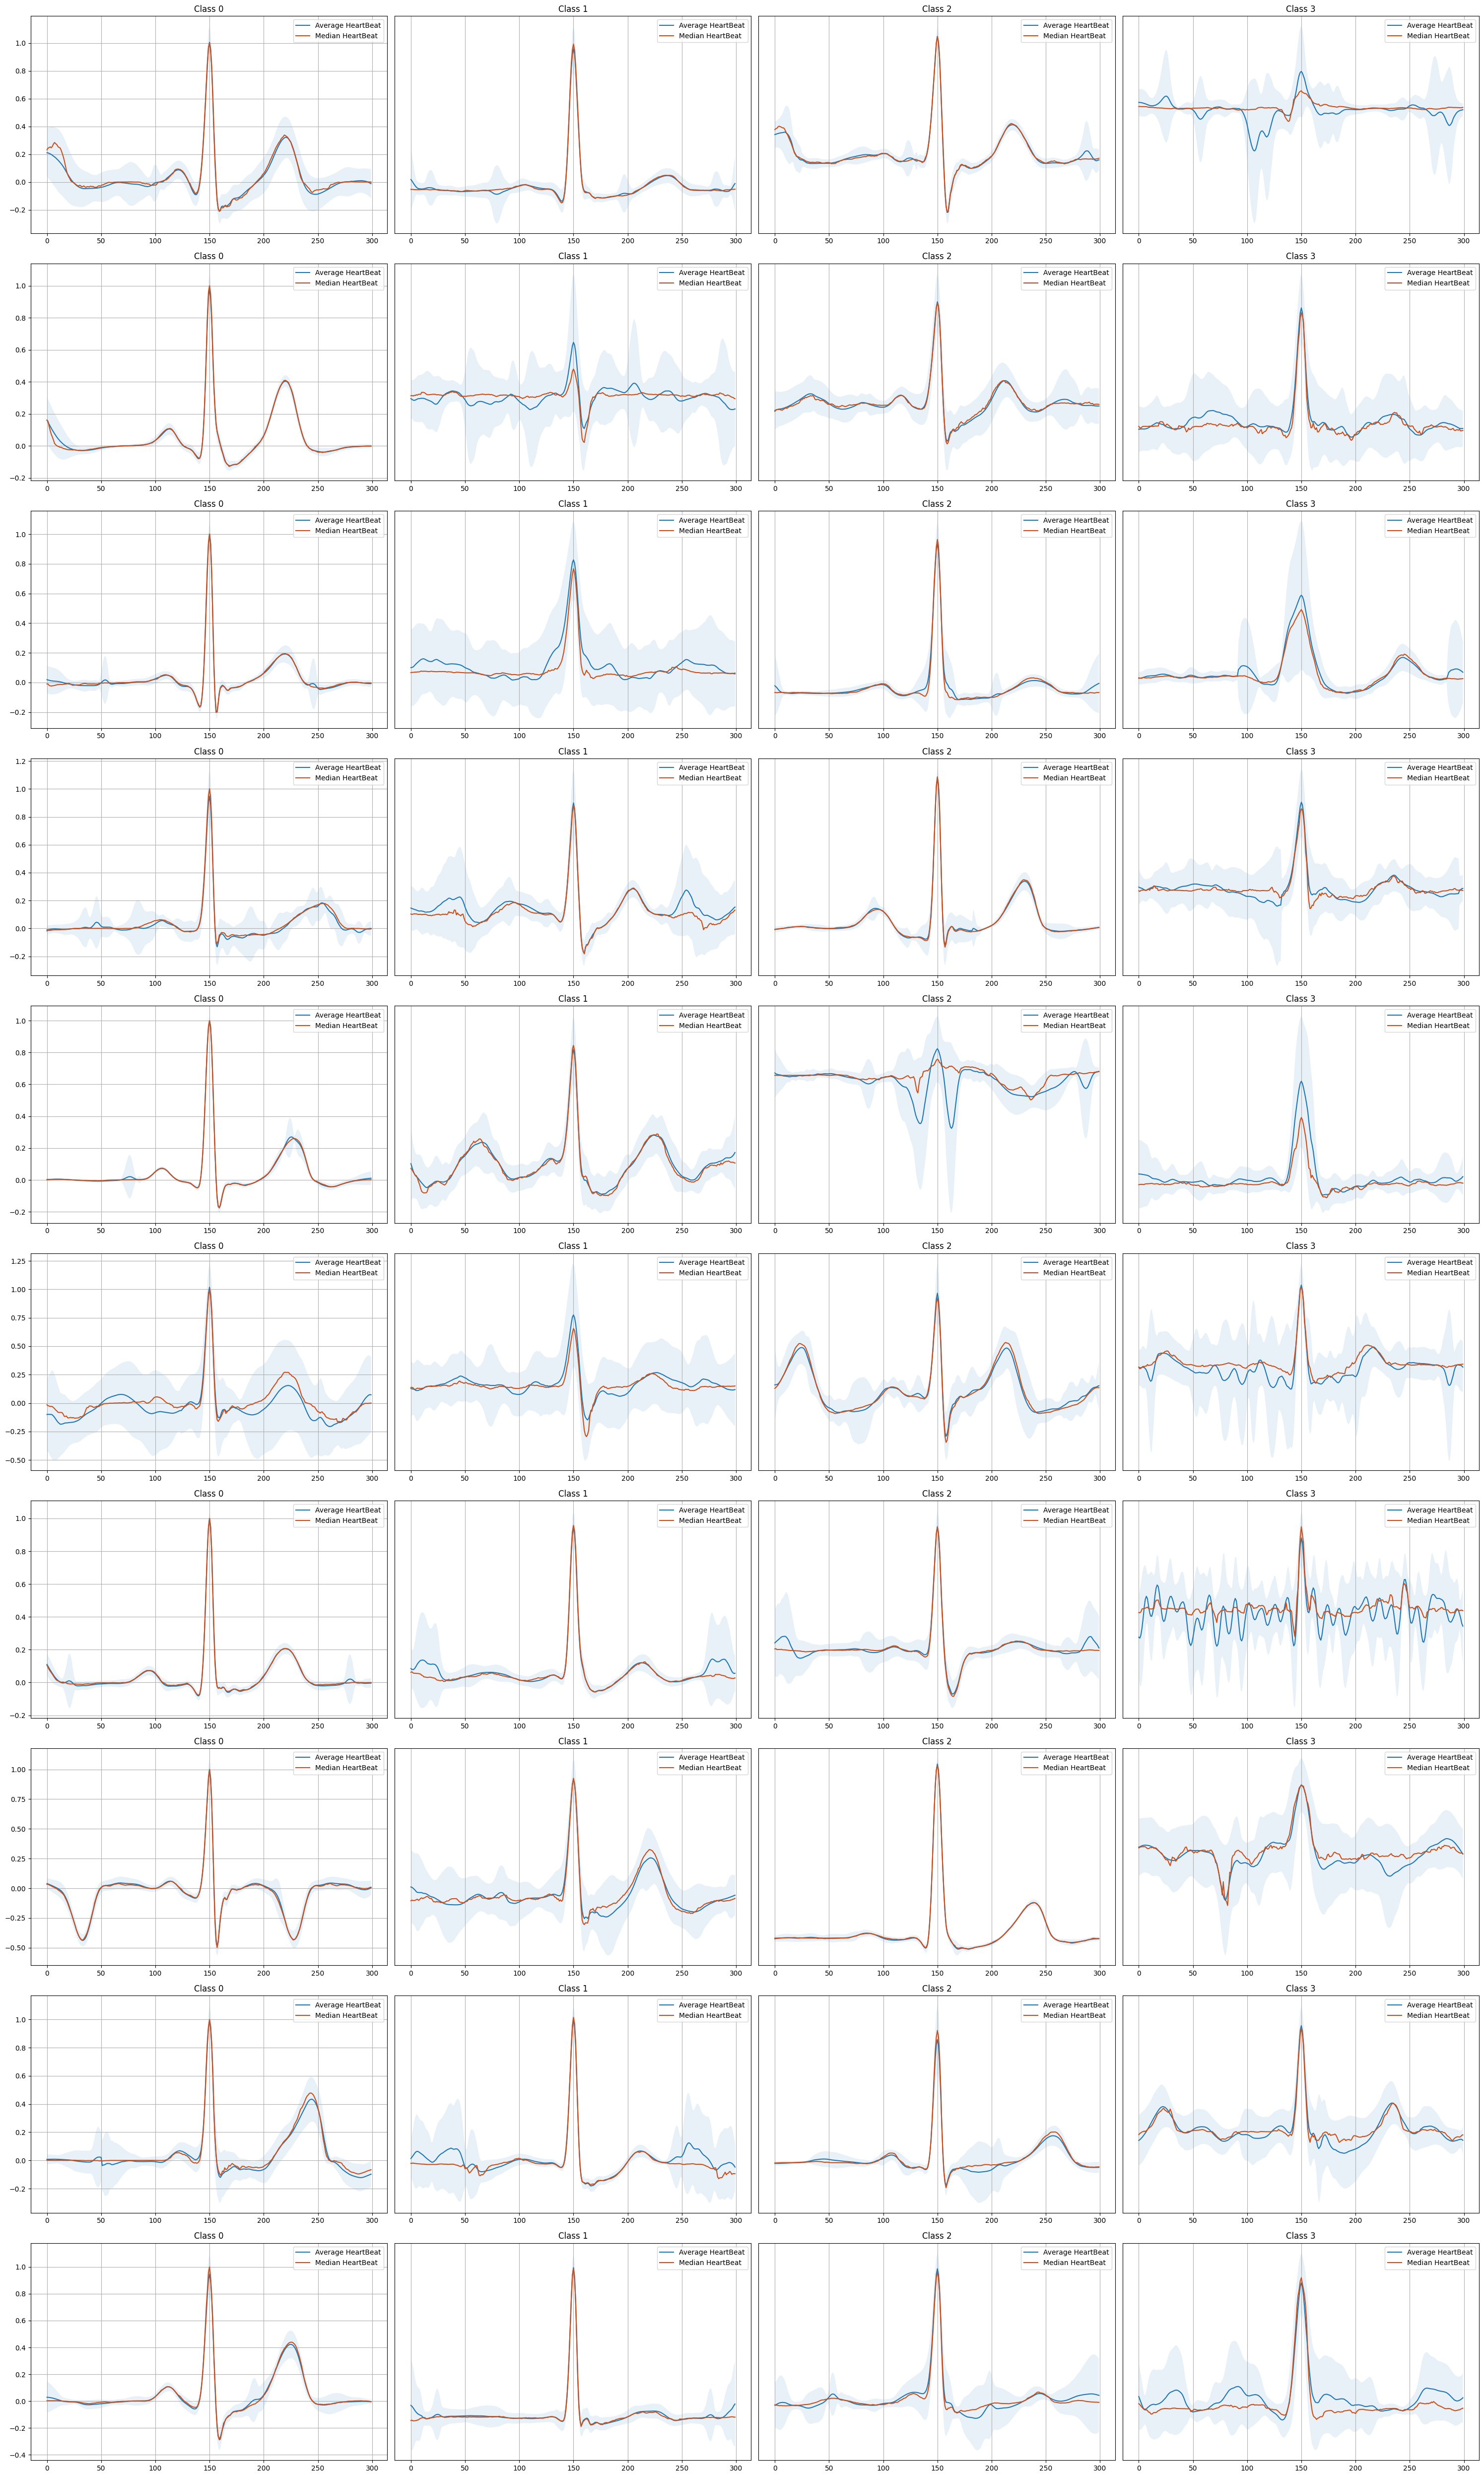

In [ ]:
import biosppy.signals.ecg as ecg

def plot_features(signal):
    
    detectors = Detectors(300)

    r_peaks = correct_rpeaks(signal, np.asarray(detectors.pan_tompkins_detector(signal)), 300, 0.2)['rpeaks']
    
    #print(r_peaks)
    if len(r_peaks) >= 2:
        #print(ecg.extract_heartbeats(signal, r_peaks, 300))
        beats = ecg.extract_heartbeats(signal, r_peaks, 300, before=.5, after=.5)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0) 
            var = np.std(beats, axis=0)
            md = np.median(beats, axis=0)
            
            plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat')
            # Fill the variance range
            plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
            # Plot a median
            plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')
            plt.legend()

plt.figure(figsize=(30, 5*num))

for class_id in range(num_classes):
    for i in range(num):
        ax = plt.subplot( num, 4, class_id + 4*i + 1)
        ax.set_title("Class {}".format(class_id))
        if class_id:
            ax.set_yticks([])
        # ax.set_ylim([-700, 1500])
        ax.grid()
        plot_features(X_train_transformed.loc[sample_signal_ids[class_id][i]].to_numpy(dtype='float32'))

plt.tight_layout()
plt.show()

for class_id in range(num_classes):
    for i in range(num):
        ax = plt.subplot( num, 4, class_id + 4*i + 1)
        ax.set_title("Class {}".format(class_id))
        if class_id:
            ax.set_yticks([])
        ax.set_ylim([-700, 1500])
        ax.grid()
        plot_features(X_train_periodic.loc[sample_signal_ids[class_id][i]].to_numpy(dtype='float32'))

plt.tight_layout()
plt.show()

In [ ]:
import random

class_distribution = y_train.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
print('Extended:')
for name in class_distribution:
    print(str(name) + ': {:}'.format(class_distribution[name] ))
print('')

y_train_np = y_train.to_numpy().squeeze()

def augment_signal(signal, max_shift, scaling_factor_range, noise_level, max_freq_change):
    # Time Shifting
    if max_shift > 0:
        shift = np.random.randint(-max_shift, max_shift)
        signal = np.roll(signal, shift)

    # Scaling
    if scaling_factor_range > 0:
        scale = np.random.uniform(1 - scaling_factor_range, 1 + scaling_factor_range)
        signal *= scale

    # Adding Noise
    if noise_level > 0:
        noise = np.random.normal(0, noise_level, size=signal.shape)
        signal += noise

    # Frequency Change (Resampling)
    if max_freq_change > 0:
        freq_change = np.random.uniform(1, 1 + max_freq_change)
        resample_size = int(len(signal) * freq_change)
        signal = np.interp(np.linspace(0, 1, resample_size), np.linspace(0, 1, len(signal)), signal)[:signal.size]

    return signal

# Parameters for augmentation
max_shift = 50  # Maximum shift for time shifting
scaling_factor_range = 0.1  # Scaling factor range for scaling
noise_level = 0.05  # Noise level for adding noise
max_freq_change = 0.1  # Maximum frequency change for resampling

# Augmenting the dataset
X_augmented = []
y_augmented = []

for class_label in [1]*5 + [2]*1 + [3]*12:
    for i in range(X_train.shape[0]):
        if y_train_np[i] == class_label:  # Define your threshold
            augmented_signal = augment_signal(X_train_transformed_np[i], max_shift, scaling_factor_range, noise_level, max_freq_change)
            X_augmented.append(augmented_signal)
            y_augmented.append(class_label)

# Convert augmented data to numpy arrays and add to original dataset
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

X_train_extended_np = np.concatenate((X_train_transformed_np, X_augmented))
y_train_extended_np = np.concatenate((y_train_np, y_augmented))

X_train_extended = pd.DataFrame(X_train_extended_np, columns=X_train.columns)
y_train_extended = pd.DataFrame(y_train_extended_np, columns=y_train.columns)

class_distribution_extended = y_train_extended.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
print('Original:')
for name in class_distribution_extended:
    print(str(name) + ': {:}'.format(class_distribution_extended[name] ))

{0: 3030, 1: 443, 2: 1474, 3: 170}


0: 3030
1: 2658
2: 2948
3: 2210


In [ ]:
# Downscaling
X_train_ready_np = X_train_extended_np[:,:-1:2]

### Possible extra features:

def rolling_count(arr, total_range, window_size):
    # Initialize a dictionary to keep track of counts
    counts = dict.fromkeys(range(total_range), 0)
    rolling_counts = []

    # Iterate through the array
    for i, num in enumerate(arr):
        # Increment count for the current number
        counts[num] += 1

        # Start counting for windows after reaching the window size
        if i >= window_size:
            # Decrement count for the number that just moved out of the window
            out_of_window_num = arr[i - window_size]
            counts[out_of_window_num] -= 1

        # Append the total count in the current window to the list
        rolling_counts.append(sum(counts.values()))

    return rolling_counts

### Example usage
arr = [random.randrange(18000) for _ in range(5000)]  # Example array
total_range = 18000
window_size = 1800

result = rolling_count(arr, total_range, window_size)
print(result)


In [ ]:
import biosppy.signals.ecg as ecg

def extract_features(signal):
    
    r_peaks = correct_rpeaks(signal, np.asarray(Detectors(300).pan_tompkins_detector(signal)), 300, 0.2)['rpeaks']
    
    beats = ecg.extract_heartbeats(signal, r_peaks, 300, before=.5, after=.5)['templates']

    # discrete features

    num_peaks = r_peaks.size

    mu_at_peak = np.mean(signal[r_peaks])
    var_at_peak = np.std(signal[r_peaks])
    md_at_peak = np.median(signal[r_peaks])

    quant_1_at_peak = np.quantile(signal[r_peaks], q=.1)
    quant_25_at_peak = np.quantile(signal[r_peaks], q=.25)
    quant_75_at_peak = np.quantile(signal[r_peaks], q=.75)
    quant_9_at_peak = np.quantile(signal[r_peaks], q=.9)

    # calculate heart rate

    # continuous features

    if len(beats) != 0:
        raise Exception()
    
    mu = np.mean(beats, axis=0) 
    var = np.std(beats, axis=0)
    md = np.median(beats, axis=0)

    quant_1 = np.quantile(beats, q=.1, axis=0)
    quant_25 = np.quantile(beats, q=.25, axis=0)
    quant_75 = np.quantile(beats, q=.75, axis=0)
    quant_9 = np.quantile(beats, q=.9, axis=0)

    return [[num_peaks, mu_at_peak, var_at_peak, md_at_peak, quant_1_at_peak, quant_25_at_peak, quant_75_at_peak, quant_9_at_peak],
             np.ndarray([[mu, var, md, quant_1, quant_25, quant_75, quant_9]])]

# OBTAIN TEST DATA

In [ ]:
X_test  = pd.read_csv(extraction_directory + 'X_test.csv', index_col='id')
X_test_np = X_test.to_numpy()

X_test_periodic = X_test.apply(replicate_row, axis=1)
X_test_periodic_np = X_test_periodic.to_numpy()

X_test_filtered = make_periodic(X_test_periodic, ms_flt_array)
X_test_filtered_np = X_test_filtered.to_numpy()

X_test_denoised_np = np.array([process_signal(row, wavelet, level, qrs_band, sampling_rate, dampening)[0:total_length] for row in X_test_filtered_np])
X_test_denoised = pd.DataFrame(data=X_test_denoised_np, columns=X_test.columns, index=X_test.index)

X_test_transformed_np = np.apply_along_axis(normalize_signal, 1, X_test_denoised_np)
X_test_transformed = pd.DataFrame(data=X_test_transformed_np, columns=X_test.columns, index=X_test.index)

X_test_ready_np = X_test_transformed_np[:,:-1:2]

In [ ]:
hh

# MODEL TRAINING

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Conv1D, Flatten, MaxPooling1D, Input, Concatenate
from keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
# Convert labels to categorical
y_train_cat_np = to_categorical(y_train_extended.to_numpy())

# Split data
X_train_partial, X_val, y_train_partial, y_val = train_test_split(X_train_ready_np, y_train_cat_np, test_size=0.2, random_state=23)

In [ ]:
learning_rate = 5e-3                            # learning rate of the gradient descent
LAMBD = 3e-3                         # lambda in L2 regularizaion
dropout = 0.2                             # dropout rate
dropout_CNN = .5
dropout_RNN = .3
recurrent_dropout = 0.0

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, GlobalAveragePooling1D, Flatten, Activation

# Model parameters
input_shape = (X_train_partial.shape[1], 1)  # Replace 'None' with your input length
num_classes = 4
dropout_rate = 0.3

model = Sequential()

for _ in range(5):
    model.add(Conv1D(64, 5, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))

# Global Average Pooling
model.add(GlobalAveragePooling1D())

fc_neurons = [64, 64, 32]
for neurons in fc_neurons:
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))

# Softmax output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 8903, 64)          384       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 4451, 64)          0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 4451, 64)          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 4451, 64)          20544     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 2225, 64)          0         
 g1D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 2225, 64)         

In [87]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=500,
                    batch_size=1024,
                    validation_split=0.0,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/500
9/9 [==============================] - 40s 4s/step - loss: 1.3773 - accuracy: 0.2719 - val_loss: 1.3267 - val_accuracy: 0.2728
Epoch 2/500
9/9 [==============================] - 39s 4s/step - loss: 1.2688 - accuracy: 0.3383 - val_loss: 1.2420 - val_accuracy: 0.4733
Epoch 3/500
9/9 [==============================] - 39s 4s/step - loss: 1.2087 - accuracy: 0.4593 - val_loss: 1.2264 - val_accuracy: 0.4765
Epoch 4/500
9/9 [==============================] - 38s 4s/step - loss: 1.1930 - accuracy: 0.4862 - val_loss: 1.1866 - val_accuracy: 0.4995
Epoch 5/500
9/9 [==============================] - 39s 4s/step - loss: 1.1422 - accuracy: 0.5453 - val_loss: 1.1473 - val_accuracy: 0.5521
Epoch 6/500
9/9 [==============================] - 39s 4s/step - loss: 1.0984 - accuracy: 0.5319 - val_loss: 0.9776 - val_accuracy: 0.5977
Epoch 7/500
9/9 [==============================] - 39s 4s/step - loss: 0.9943 - accuracy: 0.5741 - val_loss: 0.9368 - val_accuracy: 0.5949
Epoch 8/500
9/9 [==========

In [89]:
model.save("model_CNN_500_epochs.keras")

1/1 [==============================] - 2s 2s/step - loss: 0.3024 - accuracy: 0.9005
-----------------------------------------------------------------
train accuracy = 96.035%
test accuracy = 90.0461%


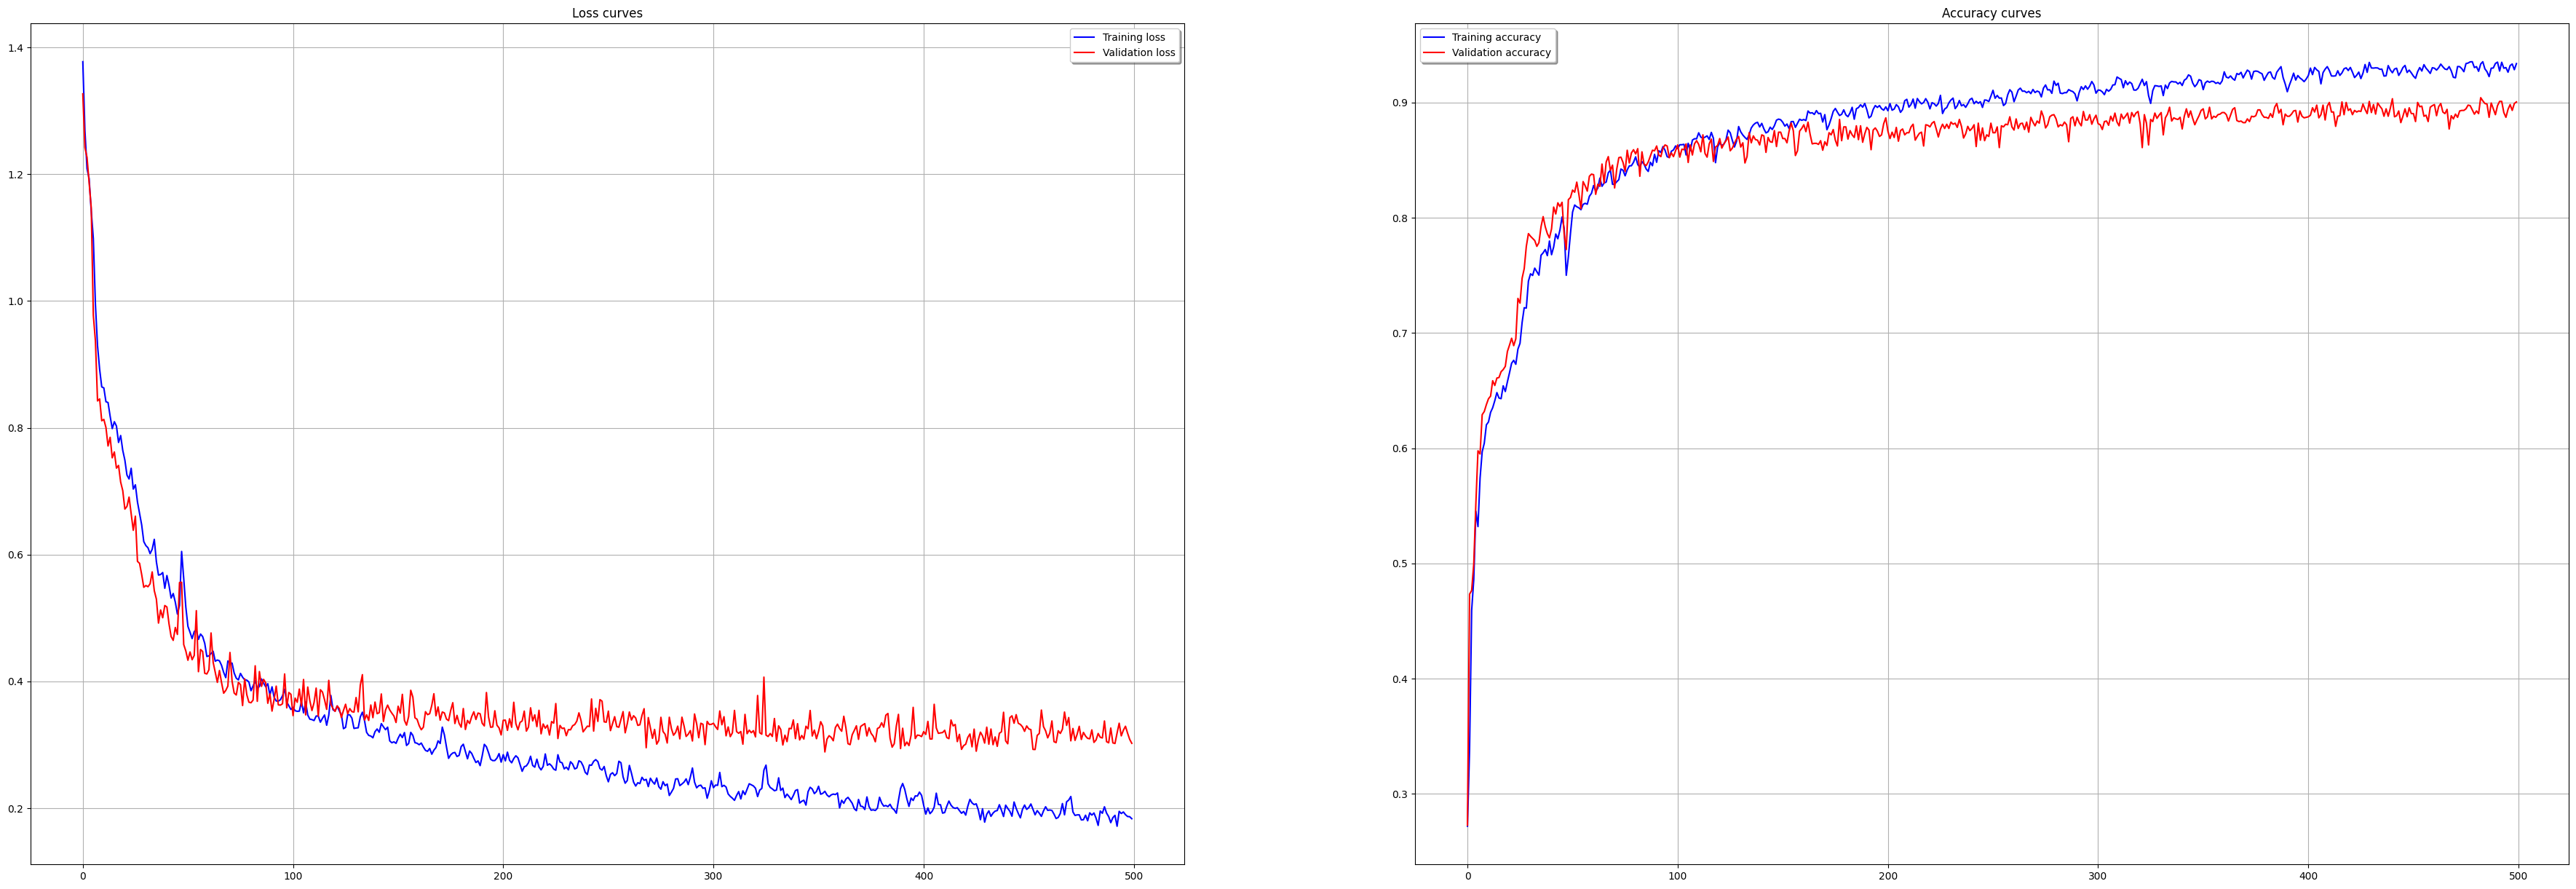

68/68 [==============================] - 3s 38ms/step
0.9004608294930876


In [90]:
# Evaluate the model:
train_loss, train_accuracy = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=X_train_partial.shape[1],
                                       verbose=1)

test_loss, test_accuracy = model.evaluate(X_val,
                                                    y_val,
                                                    batch_size=X_train_partial.shape[1],
                                                    verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(45,15))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].grid()
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].grid()
axs[1].legend(loc='best', shadow=True)
plt.show()

y_pred = model.predict(X_val)
print(f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro'))

In [110]:
y_test_pred_np = model.predict(X_test_ready_np)

y_test_pred_class_np = y_test_pred_np.argmax(axis=1)

y_test_pred_class = pd.DataFrame(data={'id': range(y_test_pred_class_np.shape[0]), 'y': y_test_pred_class_np})
y_test_pred_class.to_csv('sol_big.csv', columns=['id', 'y'], index = False)

107/107 [==============================] - 4s 39ms/step


In [125]:
class_distribution_pred = y_test_pred_class.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
class_distribution = y_train.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']

print('Original:')
for name in class_distribution:
    print(str(name) + ': {:2.1%}'.format(class_distribution[name] / y_train.size))
print('')
print('Pred:')
for name in class_distribution_pred:
    print(str(name) + ': {:2.1%}'.format(class_distribution_pred[name] / y_test_pred_class.shape[0]))

Original:
0: 59.2%
1: 8.7%
2: 28.8%
3: 3.3%

Pred:
0: 63.1%
1: 11.0%
2: 23.7%
3: 2.1%


In [ ]:
from keras.layers import Input, concatenate
from keras.models import Model

# CNN part
input_shape_cnn = (None, 1)  # Adjust based on your data
cnn_input = Input(shape=input_shape_cnn)

x = cnn_input
for _ in range(7):
    x = Conv1D(128, 5, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)

x = GlobalAveragePooling1D()(x)


# Assuming 'num_extra_features' is the number of additional features
num_extra_features = 10  # Replace with your actual number of features
extra_features_input = Input(shape=(num_extra_features,))


# Combine CNN output and extra features
combined = concatenate([x, extra_features_input])

# FCN part
fc_neurons = [256, 128, 64]
for neurons in fc_neurons:
    combined = Dense(neurons, activation='relu')(combined)
    combined = Dropout(0.5)(combined)

# Output layer
output = Dense(4, activation='softmax')(combined)

# Create the model
model = Model(inputs=[cnn_input, extra_features_input], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


In [ ]:
# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=5,
                             verbose=0,
                             factor=0.5,
                             min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=100,
                           verbose=1,
                           mode='max',
                           baseline=0.8,
                           start_from_epoch=1,
                           restore_best_weights=True)

callbacks=[lr_decay, early_stop]